In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM,BatchNormalization,GRU
from tensorflow import keras,ones_like,zeros_like
from tensorflow.keras import layers
import tensorflow as tf


Import data

In [3]:
data = pd.read_csv("D:\\học đại học\\20222\\machine learning\\data.csv")

In [4]:
time=data['Date']
data=data.drop(['Date','BTC_change'], axis=1)
target="BTC_close"


In [5]:
data.head()

,BTC_close,BTC_open,BTC_high,BTC_low,difficulty,addresses_active_count,sum_lock_weight,mean_lock_size_ytes,total_fees_usd,mean_hash_rate,...,ETH,LTC,XRP,DOGE,COPPER,GOLD,SILVER,SPX,JP225,DJI
0,29890.5,29992.8,30497.8,29590.4,52350439455487,1000988,547153915,1.650655e+06,1.292778e+06,3.565226e+08,...,1872.32,85.97,0.49401,0.065567,3.8900,1923.70,22.467,4381.89,33445.0,34210.0
1,29996.9,28307.7,30769.5,28270.5,52350439455487,920555,483181576,1.611773e+06,1.347976e+06,3.148849e+08,...,1889.87,85.12,0.49995,0.065644,3.9135,1944.90,22.810,4365.69,33390.0,34235.0
2,28307.7,26845.9,28393.0,26665.5,52350439455487,951926,543133484,1.677592e+06,1.052364e+06,3.539202e+08,...,1791.61,80.31,0.49270,0.063108,3.8835,1947.70,23.234,4388.71,33155.0,34356.0
3,26845.9,26339.7,27029.7,26295.1,52350439455487,920552,567091224,1.758290e+06,8.514319e+05,3.695343e+08,...,1737.06,77.51,0.49341,0.062429,3.8643,1964.05,24.062,0.00,0.0,0.0
4,26339.7,26515.0,26679.3,26290.6,52350439455487,883864,603064705,1.985675e+06,7.946708e+05,3.929555e+08,...,1720.98,77.20,0.48699,0.062107,3.8738,1969.45,24.198,0.00,0.0,0.0


split data to 3 sets train, valid,test sets with ratio are 70/15/15

In [6]:
train_data= data.copy().iloc[:int(0.7*len(data)),:]
train_np= train_data.to_numpy()
val_data=data.copy().iloc[int(0.7*len(data)):int(0.85*len(data)),:]
val_np=val_data.to_numpy()
test_data=data.copy().iloc[int(0.85*len(data)):,:]
test_np=test_data.to_numpy()

In [7]:
train_time=time[:int(0.7*len(data))]
val_time=time[int(0.7*len(data)):int(0.85*len(data))]
test_time=time[int(0.85*len(data)):]

In [8]:
train_np = np.asarray(train_np).astype('float32')
val_np = np.asarray(val_np).astype('float32')
test_np = np.asarray(test_np).astype('float32')

Denote time step is 40 (this means we are using 40 previous days to predict the next day)

In [9]:
time_step=40
train_time_line=[]
val_time_line=[]
test_time_line=[]

In [10]:
def scale_sequence_data(df,timesteps ,close_col_idx):
    x = []
    y = []
    timeLine=[]
    for i in range(len(df)-timesteps):    
        scaler=MinMaxScaler()      
        scaler.fit(df[i:i+timesteps,:])
        timeLine.append((scaler.data_min_[close_col_idx],scaler.data_max_[close_col_idx]))
        x.append(scaler.transform(df[i:i+timesteps,:]))
        value=df[i+timesteps].reshape(1,-1)
        value=scaler.transform(value)
        y.append(value[:,close_col_idx])

    return np.array(x),np.array(y),timeLine


In [11]:
train_x, train_y,train_time_line = scale_sequence_data(train_np, time_step,data.columns.get_loc('BTC_close'))
val_x,val_y,val_time_line =scale_sequence_data(val_np,time_step ,data.columns.get_loc('BTC_close'))
test_x, test_y,test_time_line = scale_sequence_data(test_np, time_step,data.columns.get_loc('BTC_close'))

**1.Generator**

In [12]:
class Generator(Model):
    def __init__(self,):
        super().__init__()

        self.LSTM1 = LSTM(128, return_sequences=True, recurrent_dropout=0.3)
        self.LSTM2 = LSTM(128, return_sequences=True, recurrent_dropout=0.3)
        self.LSTM3 = LSTM(64, return_sequences=False, recurrent_dropout=0.3)
        self.dense = Dense(1, activation='tanh')
        
    def call(self, inputs):
        x1 = self.LSTM1(inputs)
        x2 = self.LSTM2(x1)
        x3 = self.LSTM3(x2)
        x4 = self.dense(x3)
        return x4
        
generator = Generator()

**2.Discriminator**

In [13]:
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        self.Dense1 = Dense(128, activation=layers.LeakyReLU(alpha=0.01))
        self.Dense2 = Dense(64, activation=layers.LeakyReLU(alpha=0.01))
        self.Dense3 = Dense(64, activation=layers.LeakyReLU(alpha=0.01))
        self.Dense4 = Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        x1 = self.Dense1(inputs) 
        x2 = self.Dense2(x1)
        x3 = self.Dense3(x2)
        return self.Dense4(x3)
        
discriminator = Discriminator()


loss function

In [14]:
mse = keras.losses.MeanSquaredError()
mae = keras.losses.MeanAbsoluteError()

In [15]:
adam = keras.optimizers.legacy.Adam(
    learning_rate=0.0002
)
generator_optimizer = adam
discriminator_optimizer = adam

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = mse(ones_like(real_output), real_output)
    fake_loss = mse(zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return 3*mae(train_y.reshape((-1,1)),generator(train_x)) + mse(ones_like(fake_output), fake_output)

In [17]:
def train_step(real_x,real_y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data=generator(real_x,training=True) # [price1,price2,...]
        real_output = discriminator(real_y, training=True)
        fake_output = discriminator(generated_data, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    print("Generator loss %s | Discriminator loss %s" %(float(gen_loss), float(disc_loss)))
    print("Val loss evaluation", generator.evaluate(val_x,val_y))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return real_y, generated_data, disc_loss,gen_loss


**Train**

In [18]:
train_x[:512].shape

(512, 40, 22)

In [19]:
generator.compile(loss="MeanSquaredError")
epochs=20
batch_size=256
list_d_loss=[]
list_g_loss=[]
for i in range(epochs):
    print("*i =", i, ":")
    for j in range(0,train_x.shape[0]-batch_size-1,batch_size):
        print("*i =", i, "and j =", j, ":")
        real_x=train_x[j:batch_size+j]
        real_y=train_y[j:batch_size+j]
        real_y, generated_data,d_loss,g_loss=train_step(real_x,real_y)
        list_d_loss.append(d_loss)
        list_g_loss.append(g_loss)
        

*i = 0 :
*i = 0 and j = 0 :


Generator loss 1.5659527778625488 | Discriminator loss 0.5095130801200867
12/12 [==============================] - 1s 27ms/step - loss: 0.2620
Val loss evaluation 0.26200395822525024
*i = 0 and j = 256 :
Generator loss 1.3771140575408936 | Discriminator loss 0.5120576620101929
12/12 [==============================] - 0s 24ms/step - loss: 0.1881
Val loss evaluation 0.18810448050498962
*i = 0 and j = 512 :
Generator loss 1.28795325756073 | Discriminator loss 0.5065922737121582
12/12 [==============================] - 0s 28ms/step - loss: 0.1501
Val loss evaluation 0.1501297950744629
*i = 0 and j = 768 :
Generator loss 1.2430192232131958 | Discriminator loss 0.49845197796821594
12/12 [==============================] - 0s 33ms/step - loss: 0.1318
Val loss evaluation 0.13179221749305725
*i = 0 and j = 1024 :
Generator loss 1.2305203676223755 | Discriminator loss 0.49981197714805603
12/12 [==============================] - 1s 39ms/step - loss: 0.1273
Val loss evaluation 0.12733221054077148
*

In [20]:
generator.evaluate(test_x,test_y)

12/12 [==============================] - 1s 45ms/step - loss: 0.0384


0.03841365501284599

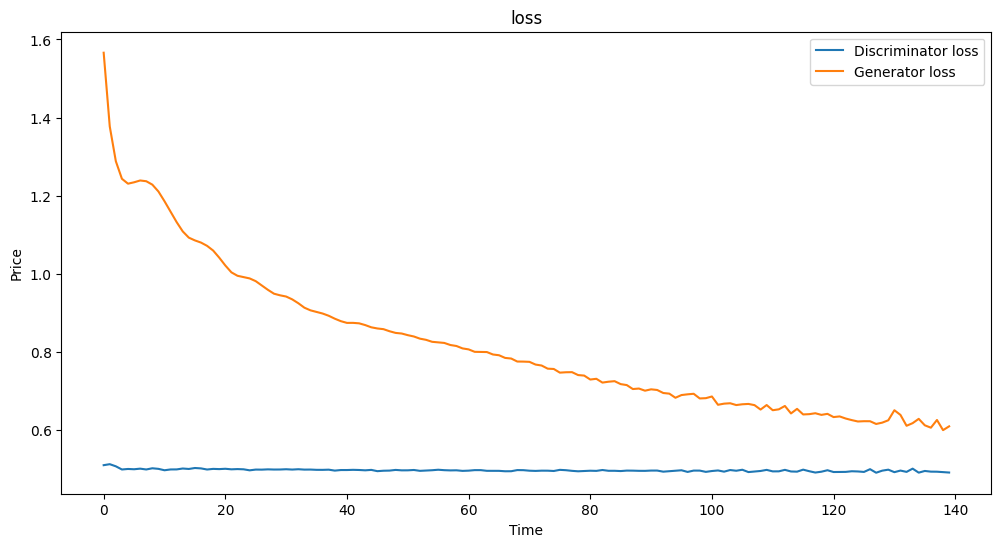

In [21]:
plt.figure(figsize=(12,6))
plt.plot(list_d_loss, label='Discriminator loss')
plt.plot(list_g_loss, label='Generator loss')

plt.title('loss')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [22]:
prediction = generator.predict(test_x)
train_pred=generator.predict(train_x)

57/57 [==============================] - 2s 38ms/step


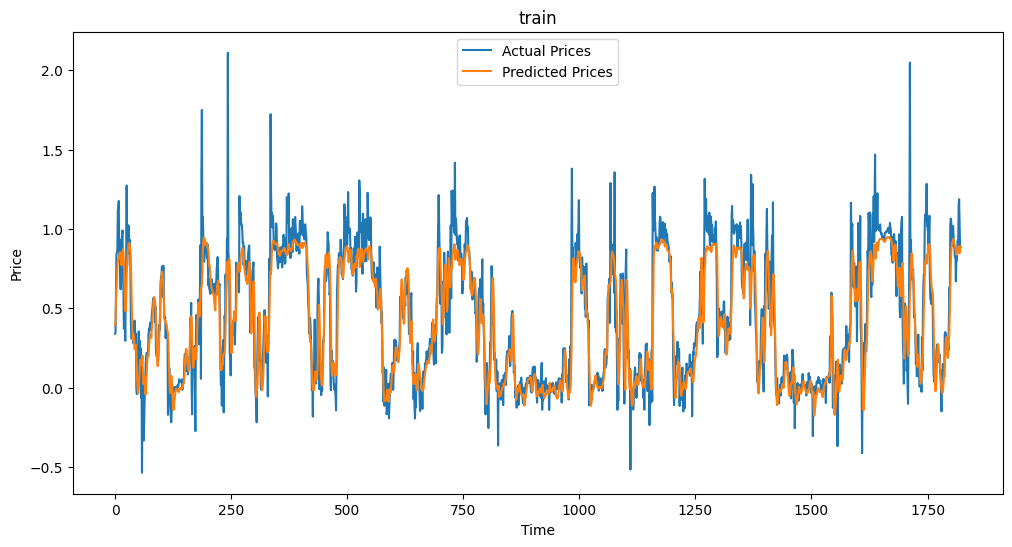

In [23]:
plt.figure(figsize=(12,6))
plt.plot(train_y, label='Actual Prices')
plt.plot(train_pred, label='Predicted Prices')

plt.title('train')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

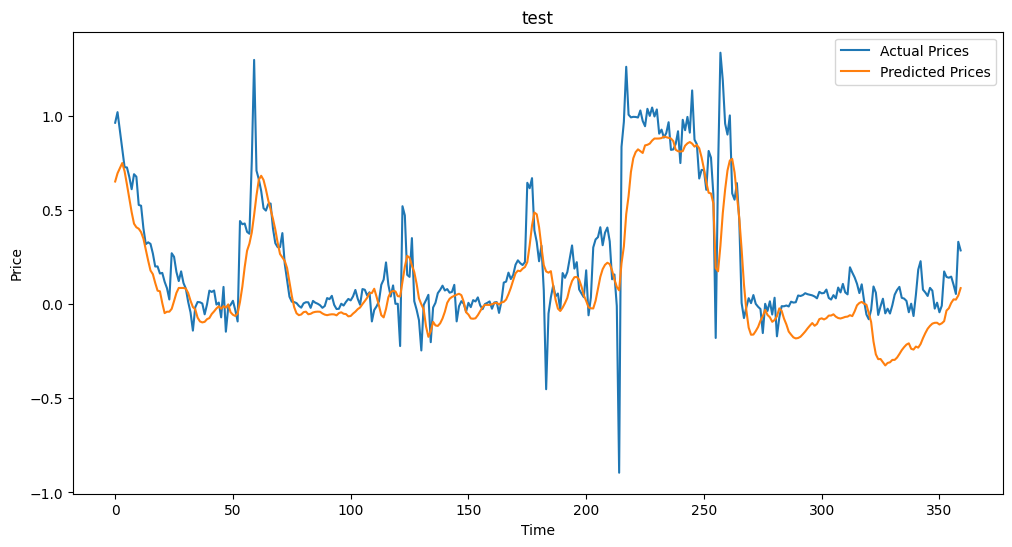

In [24]:
plt.figure(figsize=(12,6))
plt.plot(test_y, label='Actual Prices')
plt.plot(prediction, label='Predicted Prices')

plt.title('test')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [25]:
def inverseTransform(value, timeline):
    result = []
    for i in range(len(timeline)):
        min_val = timeline[i][0]
        max_val = timeline[i][1]
        original_value = (value[i] * (max_val - min_val)) + min_val
        result.append(original_value)
    return np.array(result)


In [26]:
pred_after_inverse=inverseTransform(prediction,test_time_line)
true_after_inverse=inverseTransform(test_y,test_time_line)
inverse_train_pred=inverseTransform(train_pred,train_time_line)
inverse_train_true=inverseTransform(train_y,train_time_line)

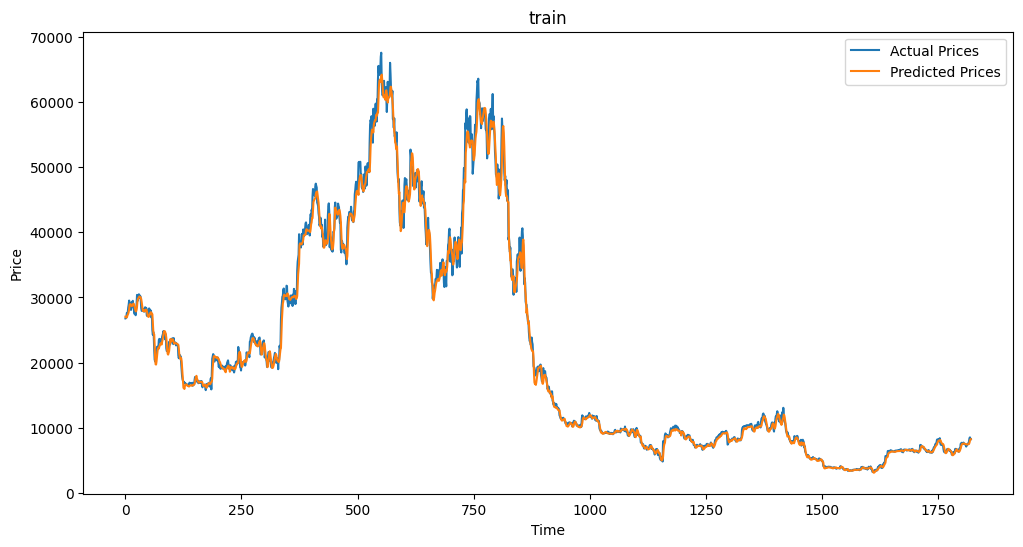

In [27]:
plt.figure(figsize=(12,6))
plt.plot(inverse_train_true, label='Actual Prices')
plt.plot(inverse_train_pred, label='Predicted Prices')

plt.title('train')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

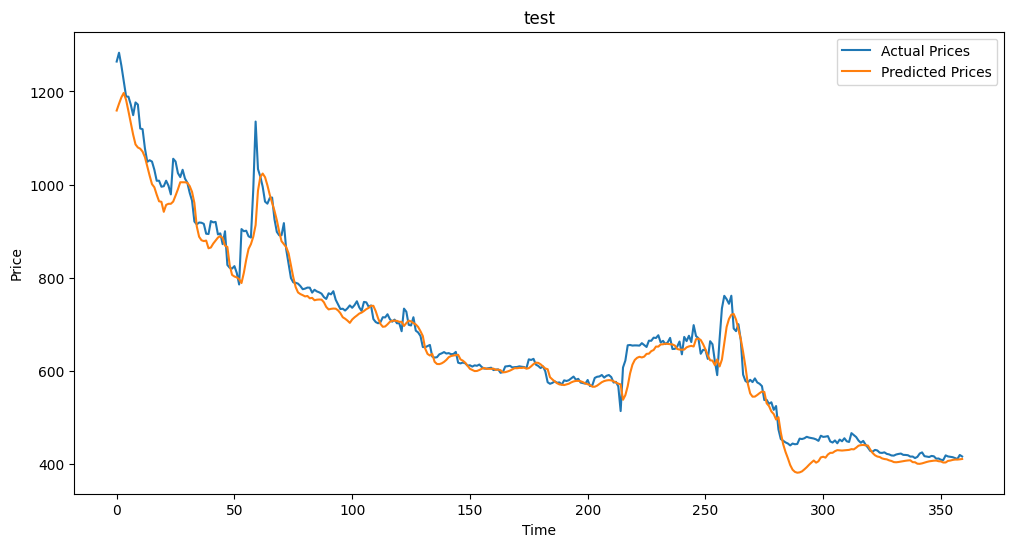

In [28]:
plt.figure(figsize=(12,6))
plt.plot(true_after_inverse, label='Actual Prices')
plt.plot(pred_after_inverse, label='Predicted Prices')

plt.title('test')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

true_train = inverse_train_true
prediction_train = inverse_train_pred
prediction_test = pred_after_inverse
true_test = true_after_inverse
def print_evaluation_results(true_values, predicted_values, dataset_name):
    print("Test ACCuracy for", dataset_name)
    print("------------------------------------------------------")
    # RMSE
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    print("Root Mean Square Error (RMSE): {:.4f}".format(rmse))
    
    # MAPE
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    print("Mean Absolute Percentage Error (MAPE): {:.4f}".format(mape))

# Print evaluation results for the train set
print_evaluation_results(true_train, prediction_train, "train set")

# Print evaluation results for the test set
print_evaluation_results(true_test, prediction_test, "test set")




Test ACCuracy for train set
------------------------------------------------------
Root Mean Square Error (RMSE): 1189.8859
Mean Absolute Percentage Error (MAPE): 0.0313
Test ACCuracy for test set
------------------------------------------------------
Root Mean Square Error (RMSE): 32.6493
Mean Absolute Percentage Error (MAPE): 0.0332
